# Single-Cell Analysis

v1.1 - [Changelog](changelog.md)

The purpose of this notebook is to give a basic example of how to perform single-cell analysis of SpaceM data, more precisely the following steps:  

- Loading multiple SpaceM datasets
- QC & Preprocessing
- Dimensionality reduction (i.e. creating a UMAP)
- Clustering
- Differential analysis

These steps are demonstrated using a SpaceM perturbation dataset generously donated by Luísa. 
If you want to run this notebook yourself, you can download the dataset [here](https://oc.embl.de/index.php/s/QIKf2EiVmZwHWbL).  
The dataset contains the metabolomes of cells subjected to one of four different treatments in order to induce metabolic changes, with five replicates for each treatment.

You are also invited to also use this notebook as a basis for your own analysis - keep in mind however that each analysis often needs to be custom-tailored to your data. Feel free to reach out to Alex if you need help!

Before you read this notebook, also consider checking out [this primer](https://scanpy.readthedocs.io/en/stable/usage-principles.html) on the core usage principles of Scanpy, the main Python package we're going to use for single-cell analysis.

### Setup


<div class="alert alert-info">

Note

Make sure to install both [Scanpy](https://scanpy.readthedocs.io/en/stable/installation.html) and [Outer SpaceM](https://mattausc.embl-community.io/outer-spacem/installation.html) before running this notebook!

</div>

In [1]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import outer_spacem as osm

%matplotlib inline
%config InlineBackend.figure_formats = ['retina']

sns.set(
    rc={
        "figure.figsize":(5, 5),
        "legend.frameon": False
    },
    style="ticks",
    context="talk"
)


In [2]:
from pathlib import Path
import os
plot_dir = Path("/Users/alberto-mac/EMBL_ATeam/projects/gastrosome_compare_conditions/single_cell/plots")
plot_dir.mkdir(exist_ok=True, parents=True)


### Loading the data

It is highly recommended you track all datasets within a SpaceM project in a central metadata table (e.g. a csv file or an Excel sheet).
If your datasets are all part of a project on METASPACE, you can use the "Export to CSV" in the project view to get a basis for this (you might need to click "see all datasets" first).

Apart from a unique dataset ID, you can also include information such as a dataset's slide number, position on said slide, as well as biologically relevant information, e.g. treatment:

In [3]:
metadata = pd.read_csv("/Users/alberto-mac/Documents/DA_ESPORTARE/LOCAL_EMBL_FILES/scratch/projects/gastrosome_processing_full/spacem/spacem_datasets_paths_filtered.csv")

metadata

datasetId                                        datasetName  \
0   2022-05-30_10h39m41s  2021-28-09_Gastrosome_Slide1control_well3_100x...   
1   2022-05-30_10h06m01s  2021-28-09_Gastrosome_Slide1control_well4_150x...   
2   2021-10-27_23h59m41s  2021-28-09_Gastrosome_Slide1control_well7_100x...   
3   2021-10-27_23h59m25s  2021-28-09_Gastrosome_Slide1control_well8_100x...   
4   2021-10-27_00h05m07s  2021-28-09_Gastrosome_Slide5Feeding_Well3_150x...   
5   2021-10-27_00h03m04s  2021-28-09_Gastrosome_Slide5Feeding_Well7_150x...   
6   2022-05-30_10h39m40s  2021-28-09_Gastrosome_Slide5Feeding_Well8_150x...   
7   2021-10-27_00h16m49s  2021-28-09_Gastrosome_Slide6Drugs_Well3_150x15...   
8   2022-05-30_10h39m39s  2021-28-09_Gastrosome_Slide6Drugs_Well4_150x15...   
9   2021-10-16_00h24m59s  2021-28-09_Gastrosome_Slide6Drugs_Well7_150x15...   
10  2021-10-27_00h20m47s  2021-28-09_Gastrosome_Slide6Drugs_Well8_150x15...   
11  2021-10-27_00h20m47s  2021-28-09_Gastrosome_Slide6Drugs_Well8_150x15...   
12  2021-10-27_00h05m07s  2021-28-09_Gastrosome_Slide5Feeding_Well3_150x...   

   condition         well  slide  replicate  MALDI_size  PreMaldi_res  \
0    Control            3      1          0         100          0.64   
1    Control            4      1          1         150          0.64   
2    Control            7      1          2         100          0.64   
3    Control            8      1          3         100          0.64   
4    Feeding            3      5          0         150          0.64   
5    Feeding            7      5          1         150          0.64   
6    Feeding            8      5          2         150          0.64   
7      Drugs            3      6          0         150          0.64   
8      Drugs            4      6          1         150          0.64   
9      Drugs            7      6          2         150          0.64   
10     Drugs            8      6          3         150          0.64   
11     Drugs  8_annotated      6          0         150          0.33   
12   Feeding  3_annotated      5          0         150          0.33   

    PostMaldi_res   group  ... maldiMatrix  analyzer resPower400  polarity  \
0            0.64  ♡EMBL♡  ...         DHB  Orbitrap       98995  positive   
1            0.64  ♡EMBL♡  ...         DHB  Orbitrap       98995  positive   
2            0.64  ♡EMBL♡  ...         DHB  Orbitrap       98995  positive   
3            0.64  ♡EMBL♡  ...         DHB  Orbitrap       98995  positive   
4            0.64  ♡EMBL♡  ...         DHB  Orbitrap       98995  positive   
5            0.64  ♡EMBL♡  ...         DHB  Orbitrap       98995  positive   
6            0.64  ♡EMBL♡  ...         DHB  Orbitrap       98995  positive   
7            0.64  ♡EMBL♡  ...         DHB  Orbitrap       98995  positive   
8            0.64  ♡EMBL♡  ...         DHB  Orbitrap       98995  positive   
9            0.64  ♡EMBL♡  ...         DHB  Orbitrap       98995  positive   
10           0.64  ♡EMBL♡  ...         DHB  Orbitrap       98995  positive   
11           0.33  ♡EMBL♡  ...         DHB  Orbitrap       98995  positive   
12           0.33  ♡EMBL♡  ...         DHB  Orbitrap       98995  positive   

             uploadDateTime  FDR@10%                  database  \
0   2021-10-26T23:23:07.396       65  SwissLipids - 2018-02-02   
1   2021-10-27T00:32:39.557      148  SwissLipids - 2018-02-02   
2   2021-10-27T23:59:41.745       94       CoreMetabolome - v3   
3   2021-10-27T23:59:25.751      113  SwissLipids - 2018-02-02   
4   2021-10-26T18:05:07.978      107  SwissLipids - 2018-02-02   
5   2021-10-27T00:03:04.917       69  SwissLipids - 2018-02-02   
6   2021-10-27T00:09:40.949       93  SwissLipids - 2018-02-02   
7   2021-10-27T00:16:49.938       34       CoreMetabolome - v3   
8   2021-10-27T00:20:59.428       74       CoreMetabolome - v3   
9   2021-10-16T00:24:59.204       83  SwissLipids - 2018-02-02   
10  2021-10-26T18:20:47.944      132  SwissLipids - 2018-02-02   


As we can see, there's 20 individual SpaceM datasets that are tracked by this table.
The benefit of a metadata table apart from letting you keep track all your datasets is that loading all your datasets now boils down to a single line of code.
To load your datasets you're going to need your metadata table (i.e. a pandas DataFrame) and a pattern that can be used to find datasets:

A couple of those samples have shown batch effects, let's exclude them:

In [20]:
metadata_subset = metadata.loc[~metadata.index.isin([11, 12]), :]
# metadata_subset = metadata
metadata_subset

datasetId                                        datasetName  \
0   2022-05-30_10h39m41s  2021-28-09_Gastrosome_Slide1control_well3_100x...   
1   2022-05-30_10h06m01s  2021-28-09_Gastrosome_Slide1control_well4_150x...   
2   2021-10-27_23h59m41s  2021-28-09_Gastrosome_Slide1control_well7_100x...   
3   2021-10-27_23h59m25s  2021-28-09_Gastrosome_Slide1control_well8_100x...   
4   2021-10-27_00h05m07s  2021-28-09_Gastrosome_Slide5Feeding_Well3_150x...   
5   2021-10-27_00h03m04s  2021-28-09_Gastrosome_Slide5Feeding_Well7_150x...   
6   2022-05-30_10h39m40s  2021-28-09_Gastrosome_Slide5Feeding_Well8_150x...   
7   2021-10-27_00h16m49s  2021-28-09_Gastrosome_Slide6Drugs_Well3_150x15...   
8   2022-05-30_10h39m39s  2021-28-09_Gastrosome_Slide6Drugs_Well4_150x15...   
9   2021-10-16_00h24m59s  2021-28-09_Gastrosome_Slide6Drugs_Well7_150x15...   
10  2021-10-27_00h20m47s  2021-28-09_Gastrosome_Slide6Drugs_Well8_150x15...   

   condition well  slide  replicate  MALDI_size  PreMaldi_res  PostMaldi_res  \
0    Control    3      1          0         100          0.64           0.64   
1    Control    4      1          1         150          0.64           0.64   
2    Control    7      1          2         100          0.64           0.64   
3    Control    8      1          3         100          0.64           0.64   
4    Feeding    3      5          0         150          0.64           0.64   
5    Feeding    7      5          1         150          0.64           0.64   
6    Feeding    8      5          2         150          0.64           0.64   
7      Drugs    3      6          0         150          0.64           0.64   
8      Drugs    4      6          1         150          0.64           0.64   
9      Drugs    7      6          2         150          0.64           0.64   
10     Drugs    8      6          3         150          0.64           0.64   

     group  ... maldiMatrix  analyzer resPower400  polarity  \
0   ♡EMBL♡  ...         DHB  Orbitrap       98995  positive   
1   ♡EMBL♡  ...         DHB  Orbitrap       98995  positive   
2   ♡EMBL♡  ...         DHB  Orbitrap       98995  positive   
3   ♡EMBL♡  ...         DHB  Orbitrap       98995  positive   
4   ♡EMBL♡  ...         DHB  Orbitrap       98995  positive   
5   ♡EMBL♡  ...         DHB  Orbitrap       98995  positive   
6   ♡EMBL♡  ...         DHB  Orbitrap       98995  positive   
7   ♡EMBL♡  ...         DHB  Orbitrap       98995  positive   
8   ♡EMBL♡  ...         DHB  Orbitrap       98995  positive   
9   ♡EMBL♡  ...         DHB  Orbitrap       98995  positive   
10  ♡EMBL♡  ...         DHB  Orbitrap       98995  positive   

             uploadDateTime  FDR@10%                  database  \
0   2021-10-26T23:23:07.396       65  SwissLipids - 2018-02-02   
1   2021-10-27T00:32:39.557      148  SwissLipids - 2018-02-02   
2   2021-10-27T23:59:41.745       94       CoreMetabolome - v3   
3   2021-10-27T23:59:25.751      113  SwissLipids - 2018-02-02   
4   2021-10-26T18:05:07.978      107  SwissLipids - 2018-02-02   
5   2021-10-27T00:03:04.917       69  SwissLipids - 2018-02-02   
6   2021-10-27T00:09:40.949       93  SwissLipids - 2018-02-02   
7   2021-10-27T00:16:49.938       34       CoreMetabolome - v3   
8   2021-10-27T00:20:59.428       74       CoreMetabolome - v3   
9   2021-10-16T00:24:59.204       83  SwissLipids - 2018-02-02   
10  2021-10-26T18:20:47.944      132  SwissLipids - 2018-02-02   

                                         opticalImage  \
0                                    No optical image   
1                                    No optical image   
2                                    No optical image   
3                                    No optical image   
4   https://metaspace2020.eu/fs/raw_optical_images...   
5                                    No optical image   
6                                    No optical image   
7                                    No optical image   
8                                    No op

In [21]:
pattern = "/Users/alberto-mac/Documents/DA_ESPORTARE/LOCAL_EMBL_FILES/scratch/projects/gastrosome_processing_full/spacem/slide{slide}/W{well}/analysis/single_cell_analysis/spatiomolecular_adata.h5ad"

This pattern contains two wildcards encased in curly brackets: `{row}` and `{col}`. 
For each dataset tracked in our metadata table, these wildcards are going to be filled with the dataset's respective column values, i.e. the `row` and `col` columns in the metadata table.

In [22]:
import warnings
warnings.simplefilter("ignore")

adata = osm.io.bulk_read(
    metadata_subset, 
    file_pattern = pattern
)

100%|██████████| 11/11 [00:00<00:00, 12.12it/s]


...and with that, the 17 selected datasets have been loaded and combined as a single `AnnData` object.  
Additionally, loading datasets this way directly includes the metadata information in our single-cell data, e.g. treatment and replicate information:

In [23]:
adata.obs[["datasetId","well", "slide", "condition", "replicate"]].sample(5)

datasetId well slide condition replicate
cell_id                                                     
39380-8  2022-05-30_10h39m39s    4     6     Drugs         1
17686-5  2021-10-27_00h03m04s    7     5   Feeding         1
4119-1   2022-05-30_10h06m01s    4     1   Control         1
64606-7  2021-10-27_00h16m49s    3     6     Drugs         0
30382-6  2022-05-30_10h39m40s    8     5   Feeding         2

### Preprocessing

#### Quality control

Let's first perform some quality control.
For starters, let's check the size of our dataset:

In [24]:
adata.shape

(86414, 329)

Our dataset consists of roughly 17000 cells described by 547 unique ions.  
Let's get some more detailed QC metrics:

In [25]:
cell_qc, ion_qc = sc.pp.calculate_qc_metrics(adata, percent_top=None)

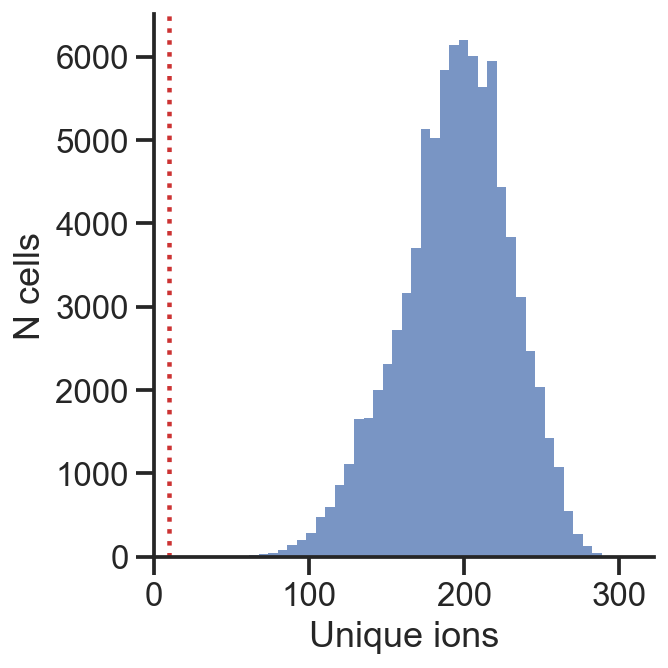

In [26]:
sns.displot(data=cell_qc, x="n_genes_by_counts", bins=50, linewidth=0)
plt.xlabel('Unique ions')
plt.ylabel('N cells')
plt.xlim(left=0)
plt.axvline(x=10, linestyle=":", c="#CC3333")
plt.show()

Seems like most of our cells have 100-200 unique ions, and there is close to 0 cells that only have very few annotations.

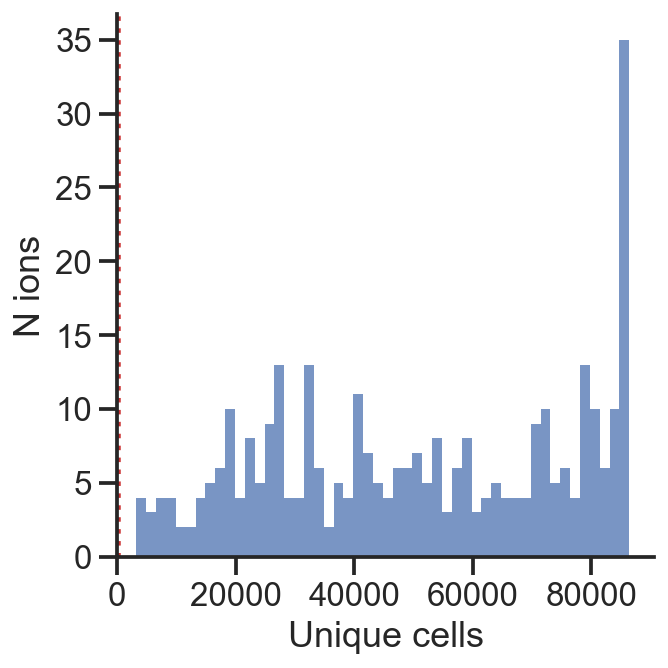

In [27]:
sns.displot(data=ion_qc, x="n_cells_by_counts", bins=50, linewidth=0)
plt.xlabel('Unique cells')
plt.ylabel('N ions')
plt.xlim(left=0)
plt.axvline(x=200, linestyle=":", c="#CC3333")
plt.show()

There seems to be plenty of ions however that only occur in a low number of cells.

#### Filtering cells and ions
Cells with only few annotations may not have been sampled by the MALDI laser sufficiently, and should therefore be removed.  
Ions that are only present in a few cells will contain only little biological information, and removing them reduces dataset complexity.
  
Keep in mind however that the threshold for both filtering steps should be adapted to your own analysis.

In [28]:
print("Cells before filtering:", adata.shape[0])

sc.pp.filter_cells(adata, min_genes=10)

print("Cells after filtering:", adata.shape[0])

Cells before filtering: 86414
Cells after filtering: 86413


In [29]:
print("Ions before filtering:", adata.shape[1])

sc.pp.filter_genes(adata, min_cells=200)

print("Ions after filtering:", adata.shape[1])

Ions before filtering: 329
Ions after filtering: 329


#### Scaling
Other single-cell omics may require you to scale intensities to achieve more normally distributed counts. For SpaceM data this is not recommended however:  

- Log (or log1p) scaling is commonly used in sequencing-based single-cell analyses to reduce data skewness, but has shown to actually drown out biological information in SpaceM data.
- Z scoring (i.e. centering to 0 and scaling to as standard deviation of 1) has no consensus even in other single-cell omics, from experience it can severely distort SpaceM data.

#### Normalization

Technical aspects of MS imaging for SpaceM cause significant variance in how much biological material is sampled, similarly to varying sequencing depth in scRNA-seq. 
As this sampling variance can severely distort downstream analysis, we're going to apply some normalization to mitigate for it.

The simplest way to do this is by scaling a cell's ion counts using a size factor porportional to the total ion count (TIC) of the cells - commonly referred to as TIC normalization:

In [30]:
sc.pp.normalize_total(adata, target_sum=1e4)

In addition to TIC normalization, we're going to apply a log1p transformation.  
This aims at reducing the skewness of the data, and at better matching the assumption of many downstream analysis tools that counts are normally distributed.

In [31]:
adata.layers["norm_counts"] = adata.X.copy() # keep raw values for diff. analysis

In [32]:
sc.pp.log1p(adata)

In [33]:
adata.raw = adata

#### Save adata to file
And then process it with LION:

In [34]:
for col in adata.obs.columns:
    adata.obs[col] = adata.obs[col].astype("str")
adata.write_h5ad(plot_dir / "../adata_processed.h5ad")

... storing 'center_x' as categorical
... storing 'center_y' as categorical
... storing 'cell_area' as categorical
... storing 'cell_sampling_area' as categorical
... storing 'cell_sampling_ratio' as categorical
... storing 'cell_nearest_cell_distance' as categorical
... storing 'centroid-0' as categorical
... storing 'centroid-1' as categorical
... storing 'bbox-0' as categorical
... storing 'bbox-1' as categorical
... storing 'bbox-2' as categorical
... storing 'bbox-3' as categorical
... storing 'local_centroid-0' as categorical
... storing 'local_centroid-1' as categorical
... storing 'area' as categorical
... storing 'filled_area' as categorical
... storing 'solidity' as categorical
... storing 'perimeter' as categorical
... storing 'euler_number' as categorical
... storing 'moments_hu-0' as categorical
... storing 'moments_central-0-0' as categorical
... storing 'moments_central-0-1' as categorical
... storing 'moments_central-0-3' as categorical
... storing 'moments_central-1-0'

### Dimensionality reduction

We'll perform some dimensionality reduction in order to get a visual overview of our data.
In short, we'll create a **U**niform **M**anifold **A**pproximation and **P**rojection (UMAP) representation of our data that will give us a overview of the 
biological (i.e. wanted) and technical (i.e. unwanted) variance within the sample e.g. similarity of cell types, conditions or replicates.

You can read more about dimensionality reduction in single-cell analysis [here](https://chanzuckerberg.github.io/scRNA-python-workshop/analysis/03-dimensionality-reduction.html).

In [ ]:
sc.pp.pca(adata)
sc.pp.neighbors(adata, random_state=12345)
sc.tl.umap(adata, random_state=12345)

In [ ]:
f = osm.pl.highlight_scatterplot(
    data = adata,
    obsm_key = "X_umap",
    hue = "condition",
    col = "condition",
    palette = "tab10",
    height = 5,
    scatter_kwargs = dict(s=5)
)

f.add_legend(markerscale=3)

plt.xticks([])
plt.yticks([])
f.savefig(plot_dir / "conditions.png")
plt.show()

Excellent! Seems like different treatments seem to be a major driver of variance in our UMAP!  
Let's take a deeper look however and also check how much variance we have between our replicates.

In [ ]:
for condition in ["Drugs", "Feeding", "Control"]:
    filtered_by_condition = adata[(adata.obs["condition"] == condition)]

    f = osm.pl.highlight_scatterplot(
        data = filtered_by_condition,
        obsm_key = "X_umap",
        hue = "replicate",
        col = "replicate",
        palette = "tab10",
        height = 5,
        scatter_kwargs = dict(s=5)
    )

    f.add_legend(markerscale=3)
    f.set_titles(condition)

    plt.xticks([])
    plt.yticks([])
    f.savefig(plot_dir / "conditions_{}.png".format(condition))
    plt.show()

We can see that mixing of replicates is not perfect (i.e. some technical variance remains in the dataset), but the biological variance we're interested in (i.e. different treatments) outweighs the technical variance.

### Clustering

Clustering cells based on their similarity is the base step in identifying biological groups (e.g. cells of the same type or metabolic states), as well as to infer differences between groups through differential analysis. Here we're going to use the Leiden algorithm to identify groups of cells.

In [ ]:
sc.tl.leiden(adata, resolution=0.2, random_state=12345)

In [ ]:
f = osm.pl.highlight_scatterplot(
    data = adata,
    obsm_key = "X_umap",
    hue = "leiden",
    col = "leiden",
    palette = "tab10",
    height = 5,
    scatter_kwargs = dict(s=5)
)

f.add_legend(markerscale=3)

plt.xticks([])
plt.yticks([])
plt.show()

As we can see above, cluster 4 covers only cells from a single replicate and is most likely artefatual. Therefore let's merge it with cluster 1:

In [ ]:
adata.obs.loc[adata.obs.leiden == "3", "leiden"] = "0"
adata.obs.leiden = adata.obs.leiden.cat.remove_unused_categories()

With some additional tweaks we can make the UMAPs a bit more visually appealing:

In [ ]:
# Create a consistent color palette
keys = adata.obs["leiden"].unique()
colors = sns.color_palette("tab10", n_colors=len(keys))

leiden_palette = dict(zip(keys, colors))

In [ ]:
adata.uns["leiden_colors"] = sns.color_palette(
    "tab10", 
    n_colors=len(adata.obs["leiden"].unique())
)

In [ ]:
f = osm.pl.highlight_scatterplot(
    data = adata,
    obsm_key = "X_umap",
    hue = "leiden",
    col = "leiden",
    decorate_titles=True, # Decorate titles
    height = 5,
    scatter_kwargs = dict(s=5),
    trim_axes = True # ...And draw some more minimalist axes
)

f.add_legend(markerscale=3)

plt.xticks([])
plt.yticks([])
f.savefig(plot_dir / "clustering.png")
plt.show()


The number of clusters the Leiden algorithm will detect depends on the `resolution` parameter, you might want to tinker around with it a little bit. In the future, Outer-SpaceM will hopefully include a tool to take care of that for you!

Once we have indentified groups of cells, we can check how cells subjected to different treatments distribute across those groups:

In [ ]:
# Register some consistent color palettes

sc.pl._utils._set_colors_for_categorical_obs(adata, "leiden", sns.color_palette("tab10")) # Need to pass color palette objects, otherwise the colors look terrible

adata.obs["condition"] = adata.obs["condition"].astype("category") # String fields need to be converted to categoricals
sc.pl._utils._set_colors_for_categorical_obs(adata, "condition", sns.color_palette("Dark2"))

In [ ]:
f = osm.pl.highlight_scatterplot(
    data = adata,
    obsm_key = "X_umap",
    hue = "condition",
    col = "leiden",
    decorate_titles = True, # Decorate titles
    height = 5,
    scatter_kwargs = dict(s=5),
    trim_axes = True # ...And draw some more minimalist axes
)

f.add_legend(markerscale=3)

plt.xticks([])
plt.yticks([])
f.savefig(plot_dir / "UMAP_conditions_vs_clusters.png")
plt.show()

In [ ]:
g = osm.pl.cross_label_counts_stacked(
    adata, 
    key_split="condition",
    key_count="leiden", 
    normalize="relative"
)
plt.savefig(plot_dir / "condition_vs_clusters.png")

plt.show()

We can also check the composition of groups. Note that here we additionally normalize by the size of each treatment's population by passing `normalize="popsize"`.

In [ ]:
g = osm.pl.cross_label_counts_stacked(
    adata, 
    key_split="leiden", 
    key_count="condition",
    normalize="popsize",
    decorate_yticks=True
)
plt.savefig(plot_dir / "clusters_vs_conditions.png")

plt.show()

For example we can see that cluster 1 is made up almost completely out of 2DG-treated cells. 

### Differential Analysis

After identifying groups of cells we might want to know what makes these groups unique, for which we are going to perform differential analysis.

<div class="alert alert-warning"> 

Warning

There are no data-backed best practices for differential analysis of SpaceM data yet. The steps currently shown here therefore use the most simplistic methods, which may not be universally applicable.
A future update to this notebook will aim to change that and provide more robust methods.

</div>

To identify which ions are differentially abundant between between groups of cells, we will use a series of 1-vs-rest wilcoxon rank-sum tests for each ion:

In [ ]:
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon", use_raw=True)

Let's check out which ions are most associated with each of our four groups:

In [ ]:
sc.pl.rank_genes_groups(adata, sharey=False, fontsize=12, gene_symbols="formula")

We can also visualize the abundance of these ions on our UMAP:

To avoid high ion intensities dominating the plots, let's apply some hotspot clipping:

In [55]:
lower, upper = np.quantile(adata.layers["norm_counts"], [0.01, 0.99], axis=0)
adata.layers["clipped"] = np.clip(adata.layers["norm_counts"], lower, upper)

In [56]:
groupname = adata.uns["rank_genes_groups"]["params"]["groupby"] # = "leiden"
top_n = 3

for group in adata.obs[groupname].unique().categories:
    df = sc.get.rank_genes_groups_df(adata, group)
    df = df.sort_values("scores", ascending=False)
    ions = df.iloc[:top_n].names.tolist()
    
    f = sc.pl.umap(
        adata,
        color=ions,
        cmap="mercury",
        s=50,
        layer="clipped",
        show=False
    )
    
    fig = f[0].figure
    fig.suptitle(f"{groupname}={group}", x=0.05, y=1, ha="left")
    fig.savefig(plot_dir / "significant_ions_leiden_{}.png".format(group))

KeyError: 'rank_genes_groups'

Furthermore, we can check the distribution of p-values and logfoldchanges in a volcano plot:

In [ ]:
pval_thres = 0.05 # upper threshold for p-values
fc_thres = 2 # lower threshold for fold changes

for group in adata.obs[groupname].unique().categories:
    df = sc.get.rank_genes_groups_df(adata, group)
    df = df.sort_values("scores", ascending=False)

    df.insert(0, groupname, group)
    
    df["significance"] = (df["pvals_adj"] < pval_thres) & (df["logfoldchanges"].abs() > np.log2(fc_thres))
    df["pvals_adj_nlog10"] = -np.log10(df["pvals_adj"] + 1e-300)
    
    plt.figure(figsize=[15, 5])
    sns.scatterplot(
        data = df,
        x = "logfoldchanges",
        y = "pvals_adj_nlog10",
        s = 10,
        linewidth = 0,
        hue = "significance",
        palette = "tab10"
    )
    plt.xlabel("Log fold change")
    plt.ylabel("-log10(p)")
    plt.legend(loc="lower left", title="Significance")
    plt.title(f"{groupname}={group}", fontsize=20)
    plt.savefig(plot_dir / "volcano_leiden_{}.png".format(group))
    plt.show()

Unfortunately, the volcano plots on SpaceM usually looks pretty messy...

Nonetheless, we can now export these markers to use them in other analyses:

In [ ]:
output_dir = plot_dir / "single-cell"

for group in adata.obs[groupname].unique().categories:
    df = sc.get.rank_genes_groups_df(adata, group)
    df = df.sort_values("scores", ascending=False)

    df.insert(0, groupname, group)
    
    df = df[
        (df["pvals"] < pval_thres) & 
        (df["logfoldchanges"].abs() > np.log2(fc_thres))
    ]

    df_path = f"{output_dir}/{groupname}_{group}_markers.tsv"
    print(df_path)
    df.to_csv(df_path, index=False, sep='\t')

# Magic
Compute and save Magic AData:


In [ ]:
adata_magic = sc.external.pp.magic(adata, name_list="all_genes", t=5, solver="approximate", copy=True)

In [ ]:
for col in adata_magic.obs.columns:
    adata_magic.obs[col] = adata_magic.obs[col].astype("str")
# adata_magic.obs.resPower400 = adata_magic.obs.resPower400.astype("str")
adata_magic.write_h5ad(plot_dir / "../adata_magic.h5ad")

In [ ]:
plot_dir = plot_dir / "../plots_magic"
plot_dir.mkdir(exist_ok=True, parents=True)


### Dimensionality reduction

We'll perform some dimensionality reduction in order to get a visual overview of our data.
In short, we'll create a **U**niform **M**anifold **A**pproximation and **P**rojection (UMAP) representation of our data that will give us a overview of the
biological (i.e. wanted) and technical (i.e. unwanted) variance within the sample e.g. similarity of cell types, conditions or replicates.

You can read more about dimensionality reduction in single-cell analysis [here](https://chanzuckerberg.github.io/scRNA-python-workshop/analysis/03-dimensionality-reduction.html).

In [33]:
sc.pp.pca(adata_magic)
sc.pp.neighbors(adata_magic, random_state=12345)
sc.tl.umap(adata_magic, random_state=12345)

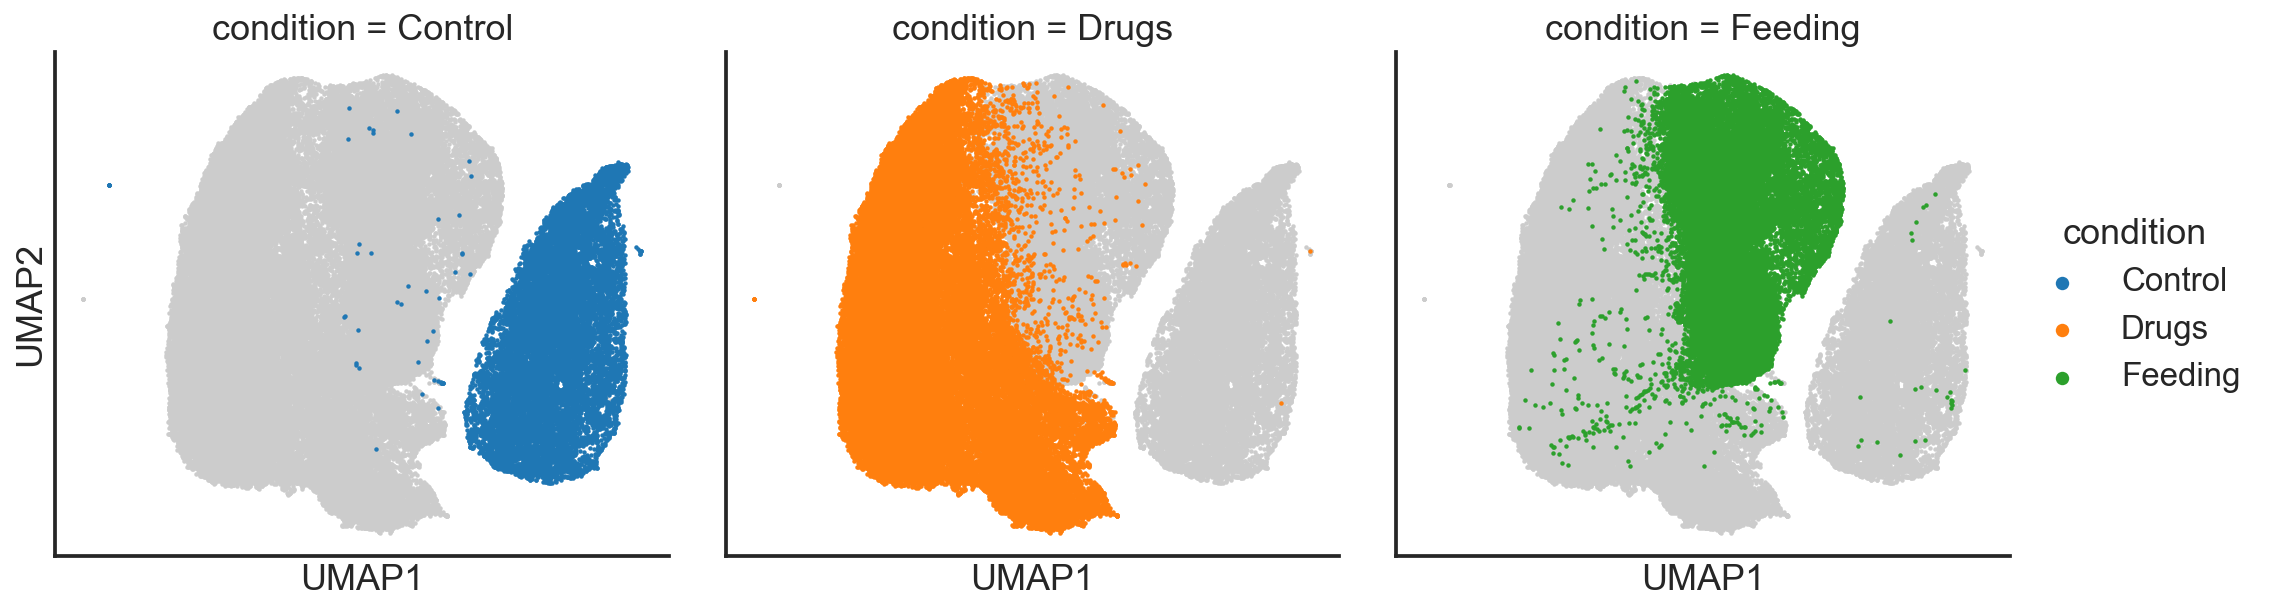

In [34]:
f = osm.pl.highlight_scatterplot(
    data = adata_magic,
    obsm_key = "X_umap",
    hue = "condition",
    col = "condition",
    palette = "tab10",
    height = 5,
    scatter_kwargs = dict(s=5)
)

f.add_legend(markerscale=3)

plt.xticks([])
plt.yticks([])
f.savefig(plot_dir / "conditions.png")
plt.show()

Excellent! Seems like different treatments seem to be a major driver of variance in our UMAP!
Let's take a deeper look however and also check how much variance we have between our replicates.

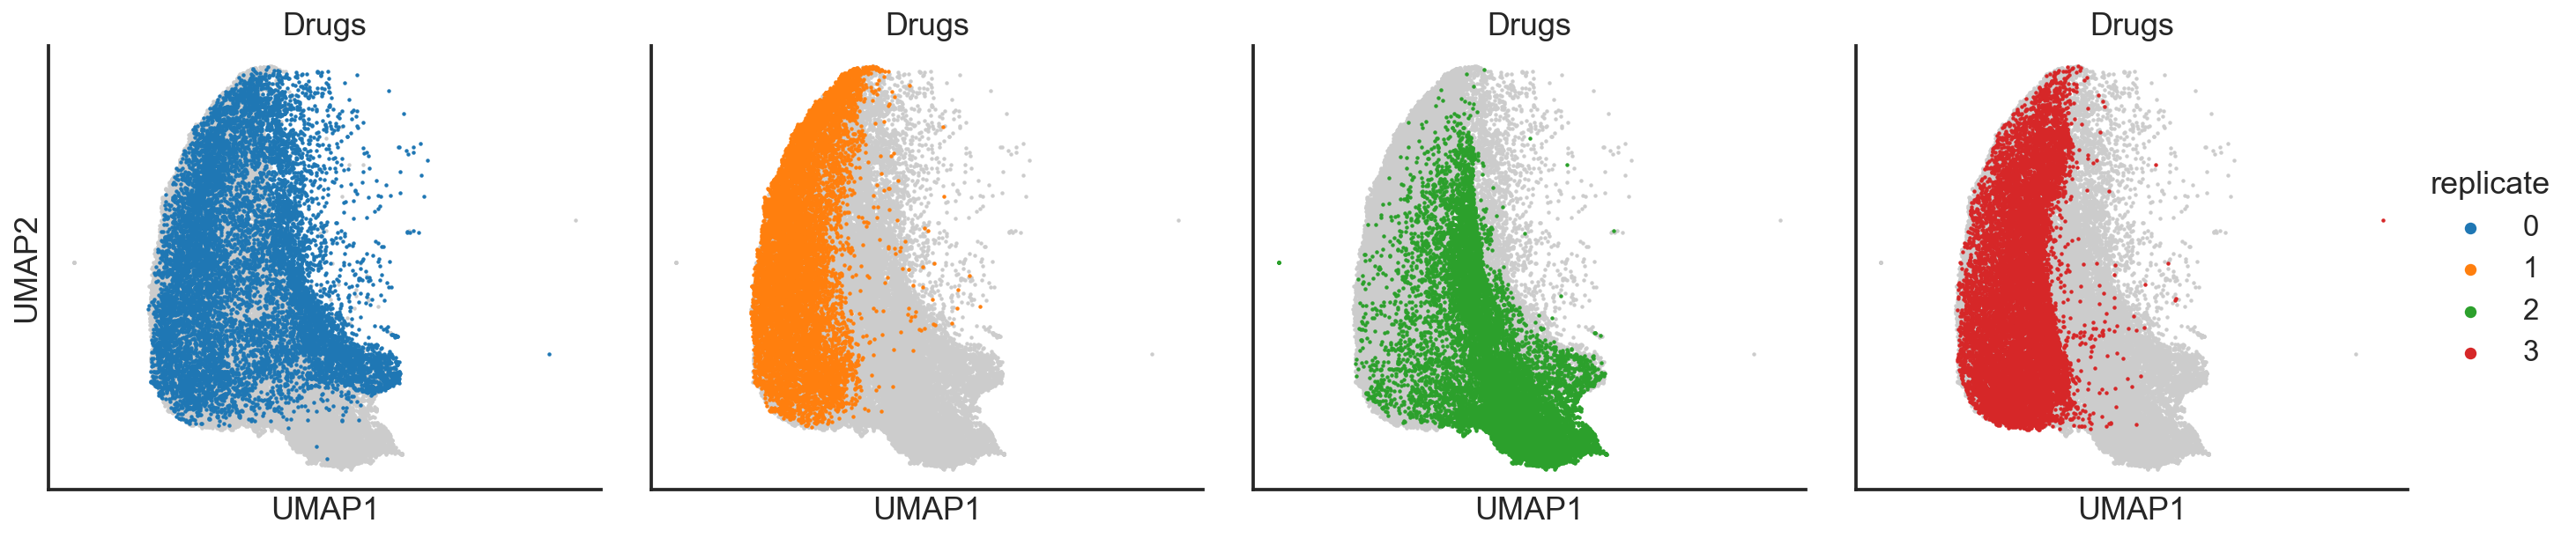

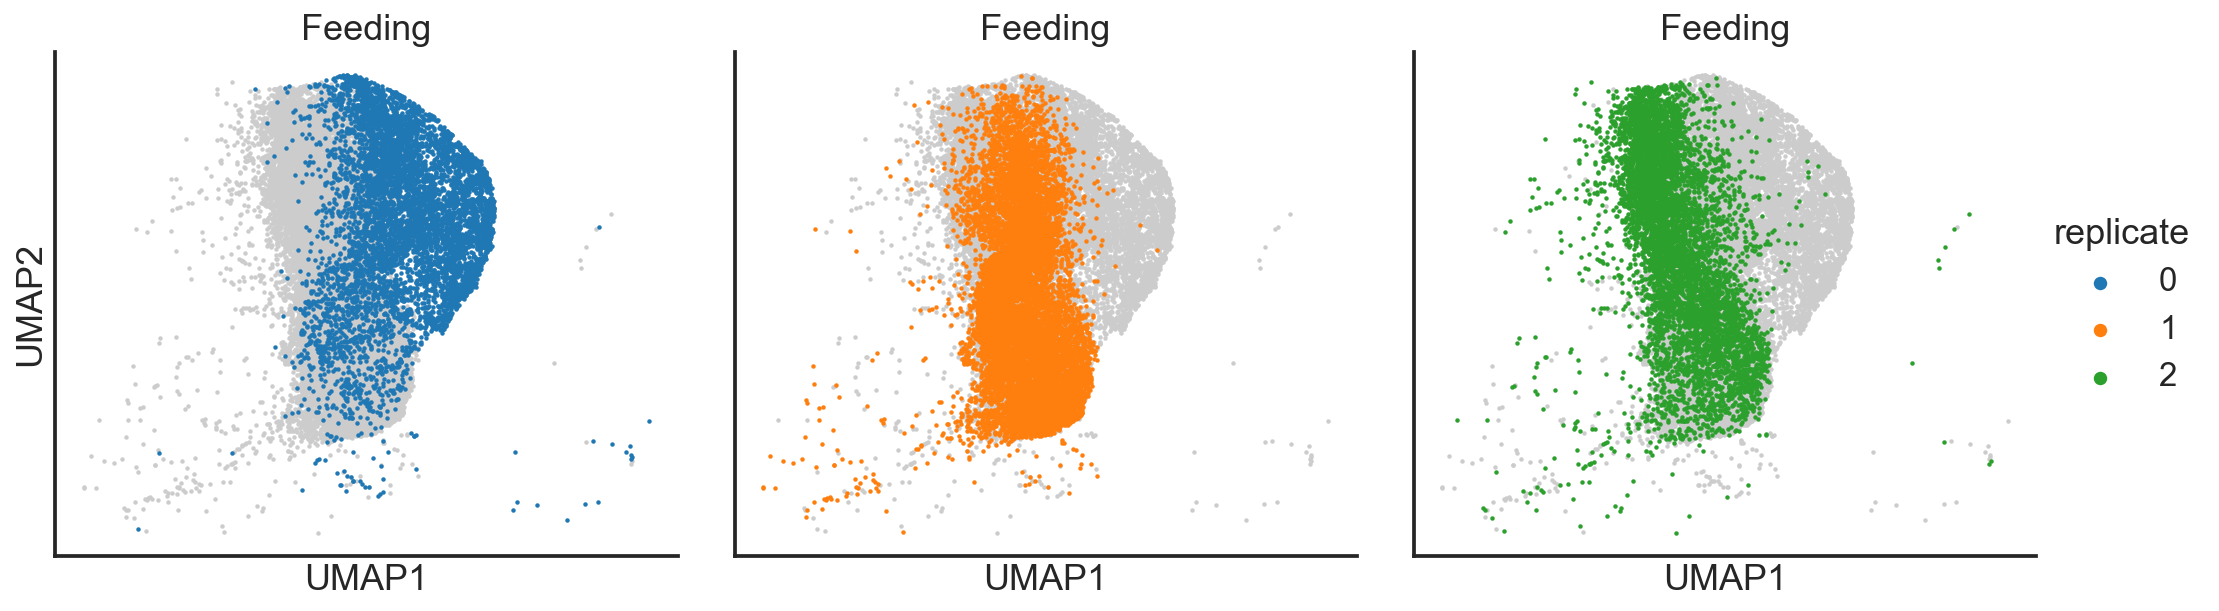

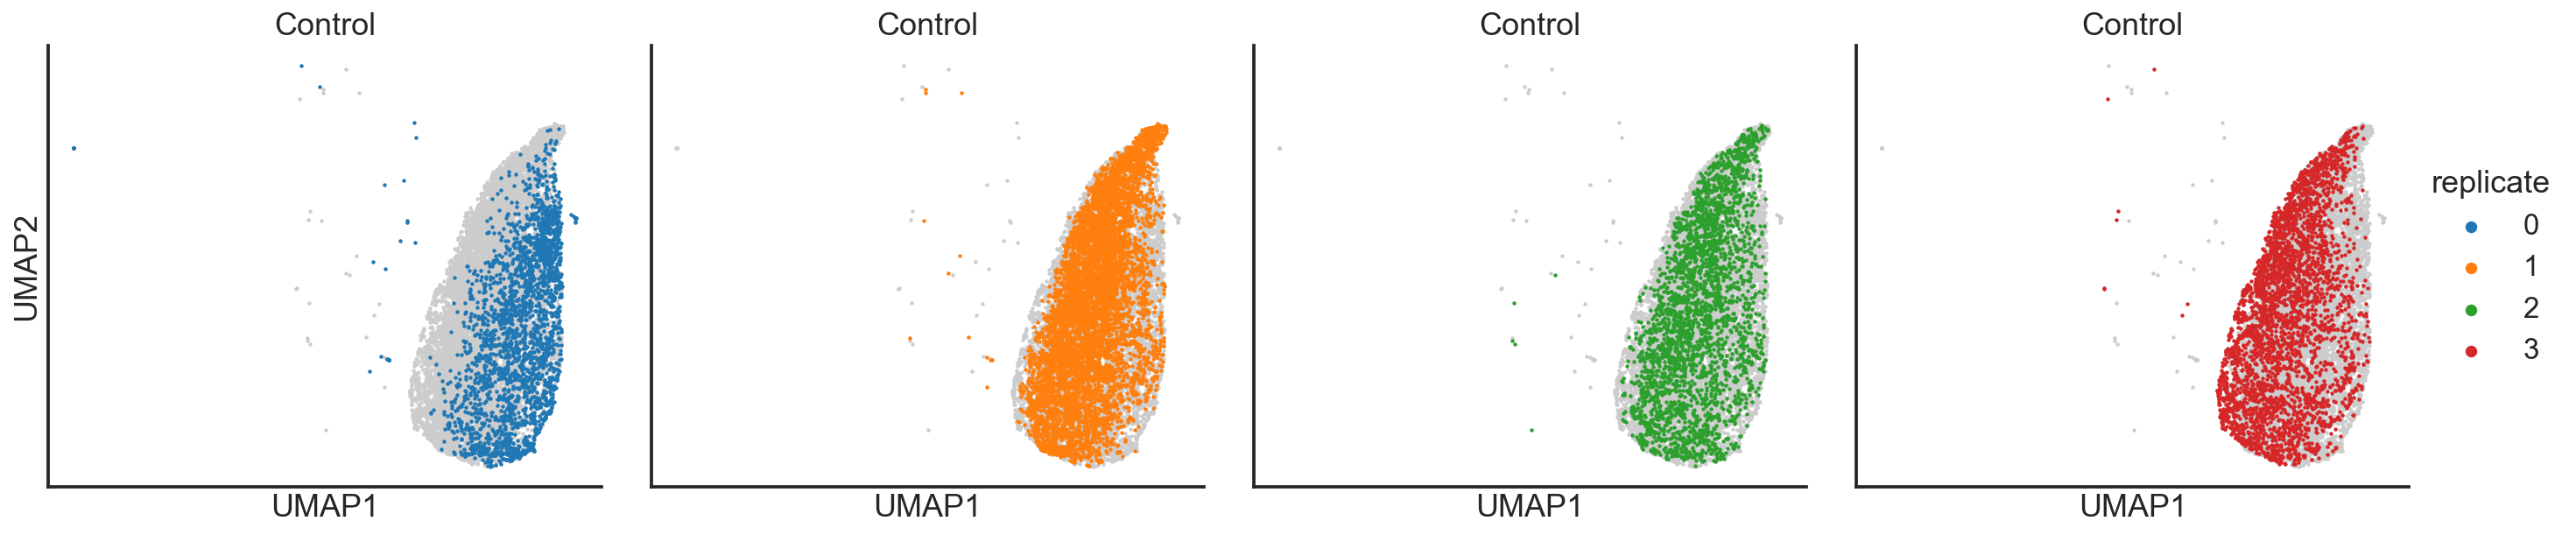

In [35]:
for condition in ["Drugs", "Feeding", "Control"]:
    filtered_by_condition = adata_magic[(adata_magic.obs["condition"] == condition)]

    f = osm.pl.highlight_scatterplot(
        data = filtered_by_condition,
        obsm_key = "X_umap",
        hue = "replicate",
        col = "replicate",
        palette = "tab10",
        height = 5,
        scatter_kwargs = dict(s=5)
    )

    f.add_legend(markerscale=3)
    f.set_titles(condition)

    plt.xticks([])
    plt.yticks([])
    f.savefig(plot_dir / "conditions_{}.png".format(condition))
    plt.show()

We can see that mixing of replicates is not perfect (i.e. some technical variance remains in the dataset), but the biological variance we're interested in (i.e. different treatments) outweighs the technical variance.

### Clustering

Clustering cells based on their similarity is the base step in identifying biological groups (e.g. cells of the same type or metabolic states), as well as to infer differences between groups through differential analysis. Here we're going to use the Leiden algorithm to identify groups of cells.

In [42]:
sc.tl.leiden(adata_magic, resolution=0.02, random_state=12345)

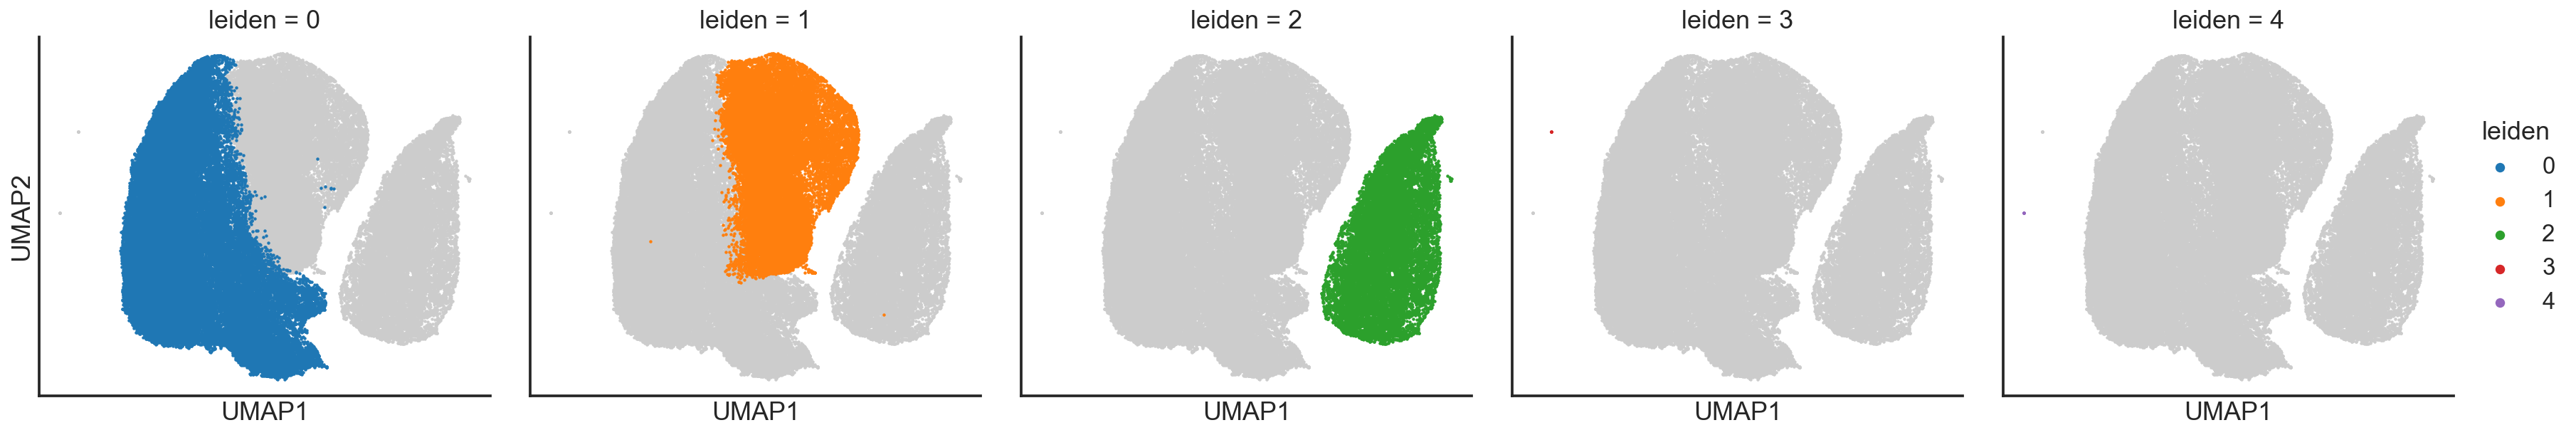

In [43]:
f = osm.pl.highlight_scatterplot(
    data = adata_magic,
    obsm_key = "X_umap",
    hue = "leiden",
    col = "leiden",
    palette = "tab10",
    height = 5,
    scatter_kwargs = dict(s=5)
)

f.add_legend(markerscale=3)

plt.xticks([])
plt.yticks([])
plt.show()

As we can see above, cluster 4 covers only cells from a single replicate and is most likely artefatual. Therefore let's merge it with cluster 1:

In [44]:
adata_magic.obs.loc[adata_magic.obs.leiden == "3", "leiden"] = "0"
adata_magic.obs.loc[adata_magic.obs.leiden == "4", "leiden"] = "0"
adata_magic.obs.leiden = adata_magic.obs.leiden.cat.remove_unused_categories()

With some additional tweaks we can make the UMAPs a bit more visually appealing:

In [45]:
# Create a consistent color palette
keys = adata_magic.obs["leiden"].unique()
colors = sns.color_palette("tab10", n_colors=len(keys))

leiden_palette = dict(zip(keys, colors))

In [46]:
adata_magic.uns["leiden_colors"] = sns.color_palette(
    "tab10",
    n_colors=len(adata_magic.obs["leiden"].unique())
)

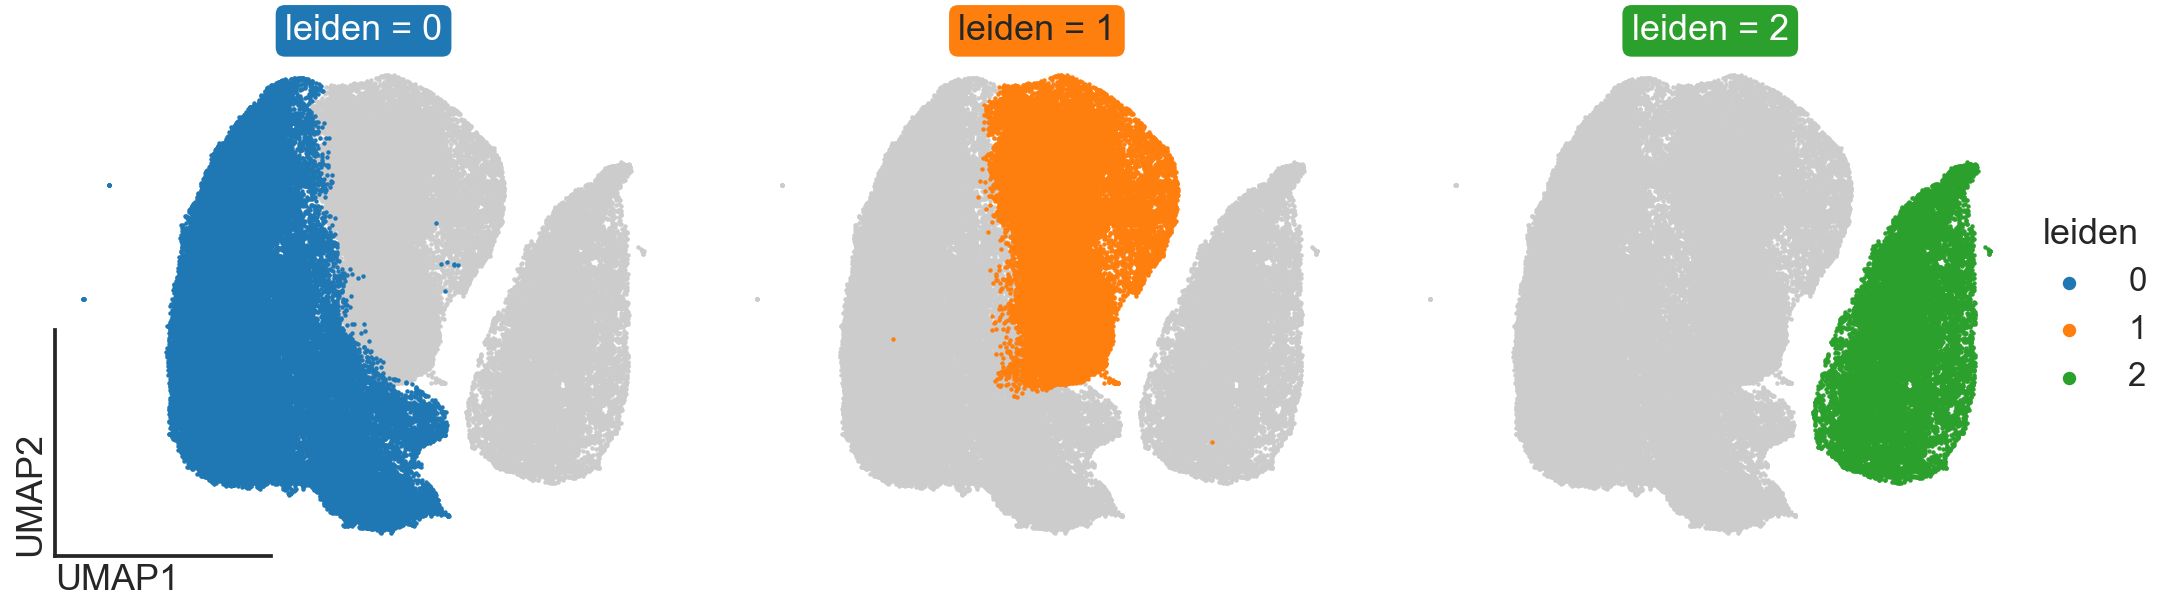

In [47]:
f = osm.pl.highlight_scatterplot(
    data = adata_magic,
    obsm_key = "X_umap",
    hue = "leiden",
    col = "leiden",
    decorate_titles=True, # Decorate titles
    height = 5,
    scatter_kwargs = dict(s=5),
    trim_axes = True # ...And draw some more minimalist axes
)

f.add_legend(markerscale=3)

plt.xticks([])
plt.yticks([])
f.savefig(plot_dir / "clustering.png")
plt.show()


The number of clusters the Leiden algorithm will detect depends on the `resolution` parameter, you might want to tinker around with it a little bit. In the future, Outer-SpaceM will hopefully include a tool to take care of that for you!

Once we have indentified groups of cells, we can check how cells subjected to different treatments distribute across those groups:

In [48]:
# Register some consistent color palettes

sc.pl._utils._set_colors_for_categorical_obs(adata_magic, "leiden", sns.color_palette("tab10")) # Need to pass color palette objects, otherwise the colors look terrible

adata_magic.obs["condition"] = adata_magic.obs["condition"].astype("category") # String fields need to be converted to categoricals
sc.pl._utils._set_colors_for_categorical_obs(adata_magic, "condition", sns.color_palette("Dark2"))

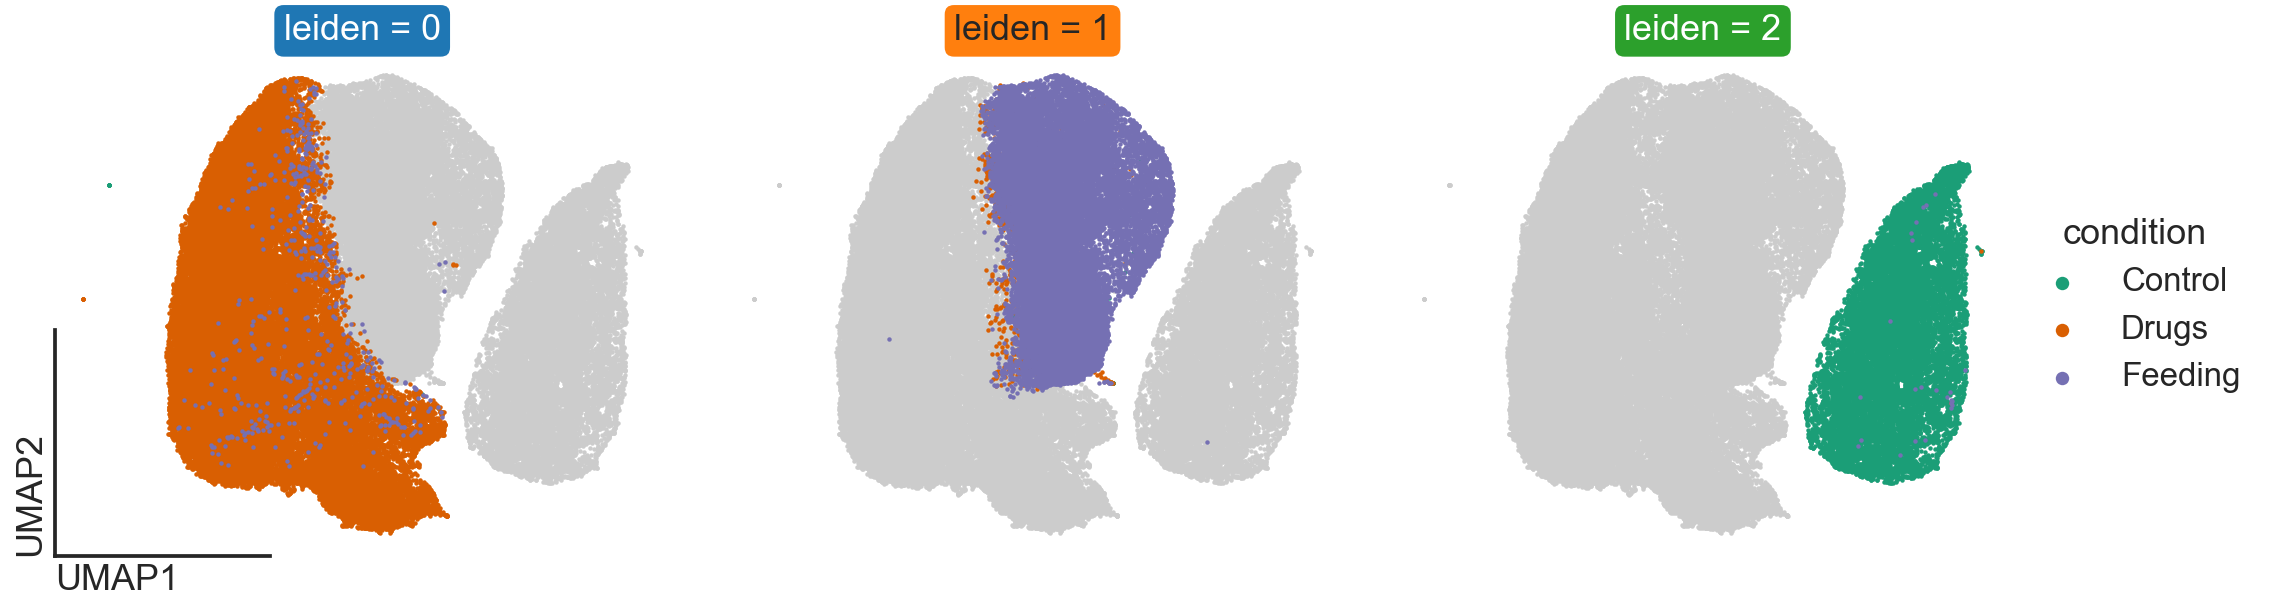

In [49]:
f = osm.pl.highlight_scatterplot(
    data = adata_magic,
    obsm_key = "X_umap",
    hue = "condition",
    col = "leiden",
    decorate_titles = True, # Decorate titles
    height = 5,
    scatter_kwargs = dict(s=5),
    trim_axes = True # ...And draw some more minimalist axes
)

f.add_legend(markerscale=3)

plt.xticks([])
plt.yticks([])
f.savefig(plot_dir / "UMAP_conditions_vs_clusters.png")
plt.show()

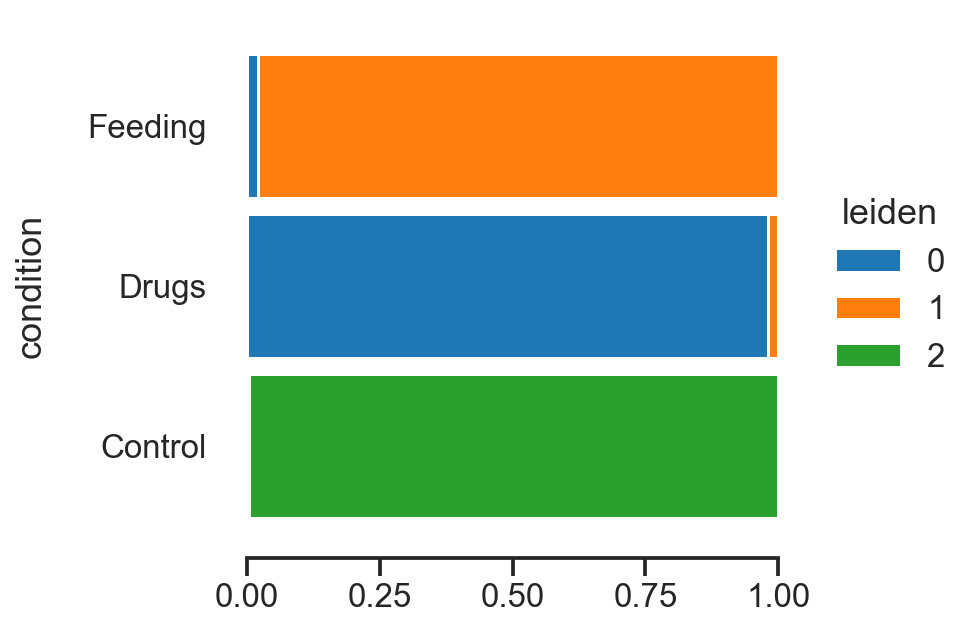

In [50]:
g = osm.pl.cross_label_counts_stacked(
    adata_magic,
    key_split="condition",
    key_count="leiden",
    normalize="relative"
)
plt.savefig(plot_dir / "condition_vs_clusters.png")

plt.show()

We can also check the composition of groups. Note that here we additionally normalize by the size of each treatment's population by passing `normalize="popsize"`.

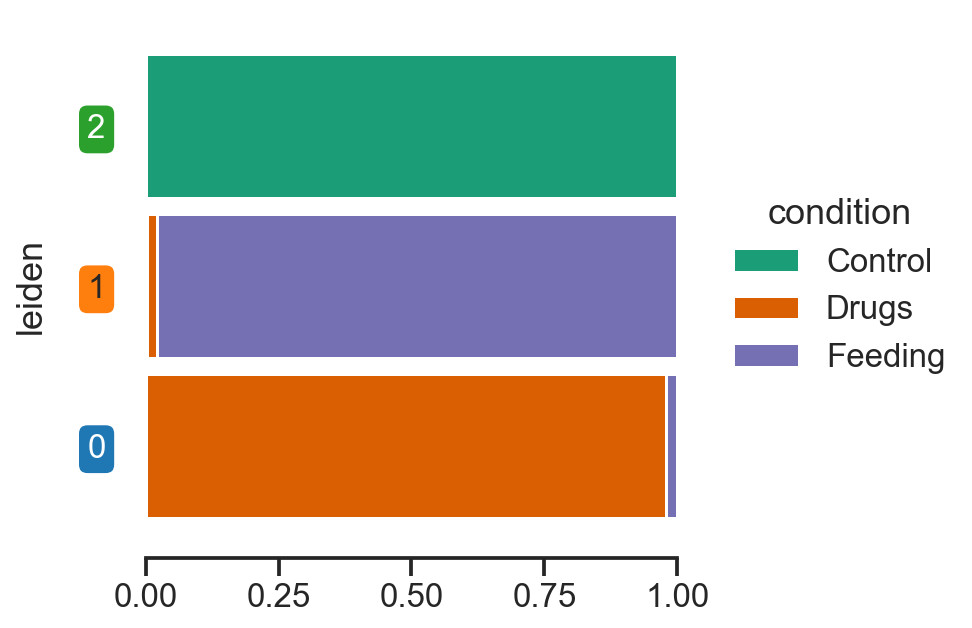

In [51]:
g = osm.pl.cross_label_counts_stacked(
    adata_magic,
    key_split="leiden",
    key_count="condition",
    normalize="popsize",
    decorate_yticks=True
)
plt.savefig(plot_dir / "clusters_vs_conditions.png")

plt.show()

For example we can see that cluster 1 is made up almost completely out of 2DG-treated cells.


In [52]:
sc.tl.rank_genes_groups(adata_magic, groupby="leiden", method="wilcoxon", use_raw=True)

Let's check out which ions are most associated with each of our four groups:

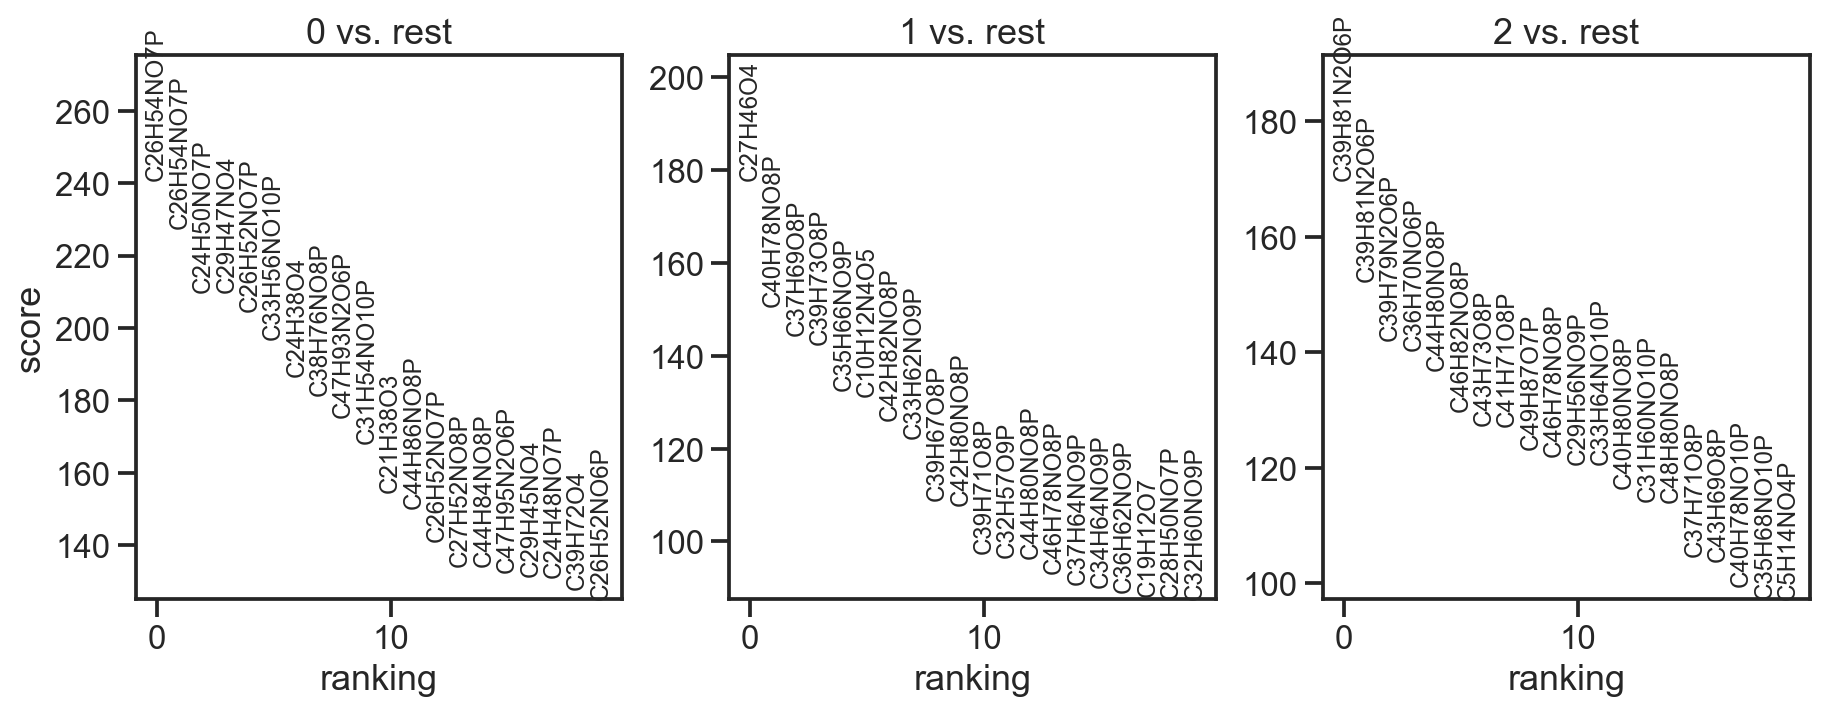

In [53]:
sc.pl.rank_genes_groups(adata_magic, sharey=False, fontsize=12, gene_symbols="formula")

We can also visualize the abundance of these ions on our UMAP:

To avoid high ion intensities dominating the plots, let's apply some hotspot clipping:

In [57]:
adata_magic.layers["norm_counts"] = adata_magic.X.copy()
lower, upper = np.quantile(adata_magic.layers["norm_counts"], [0.01, 0.99], axis=0)
adata_magic.layers["clipped"] = np.clip(adata_magic.layers["norm_counts"], lower, upper)

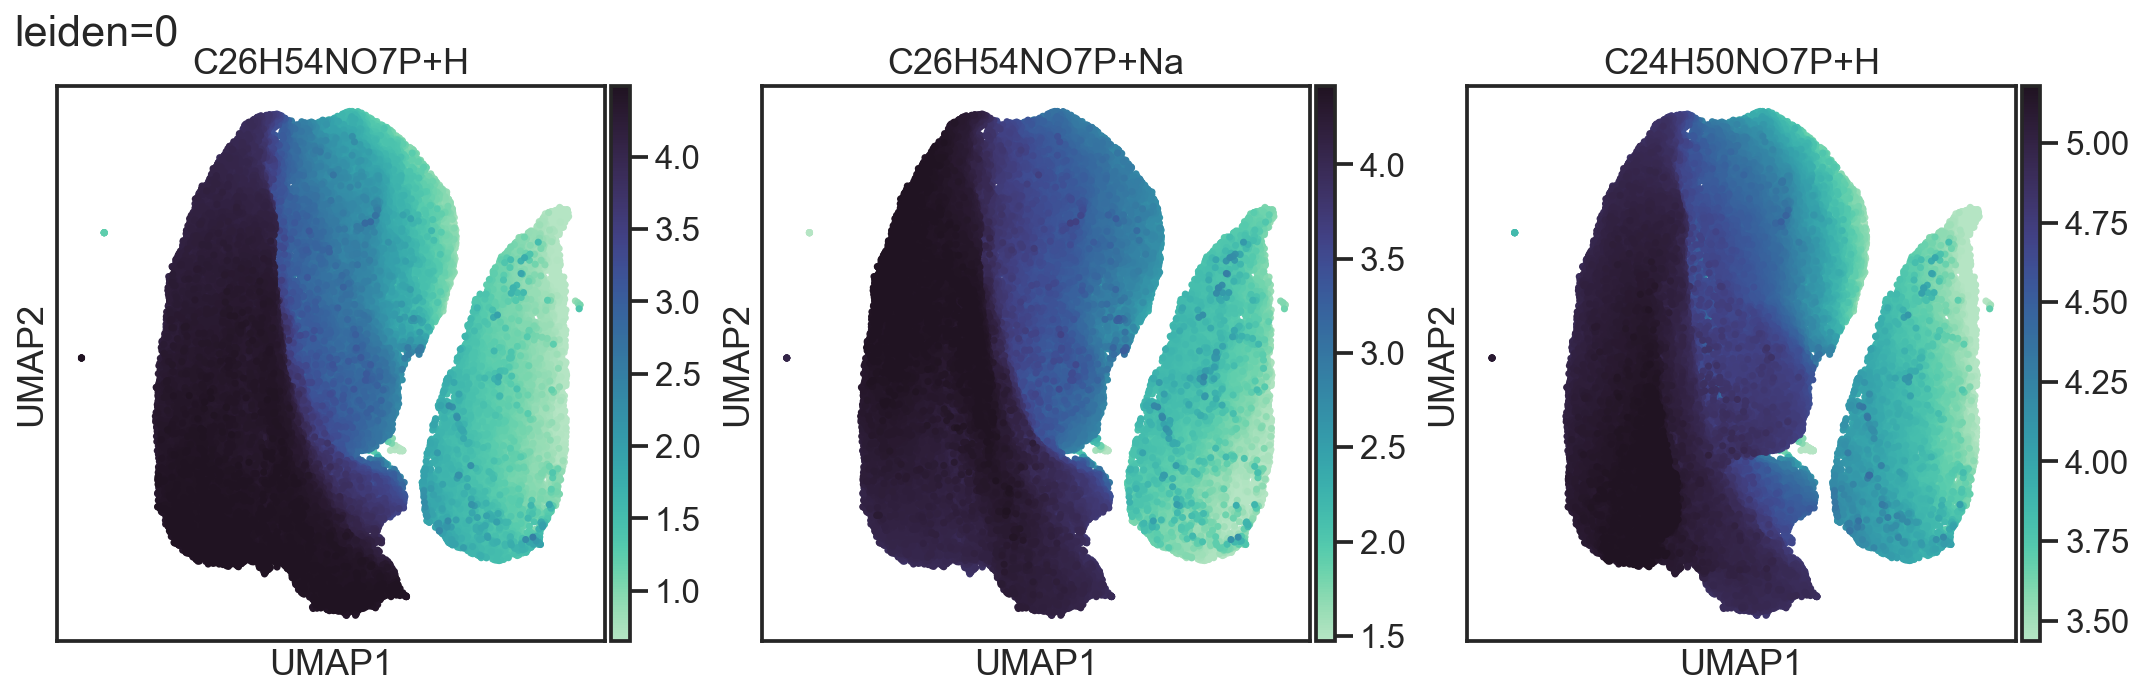

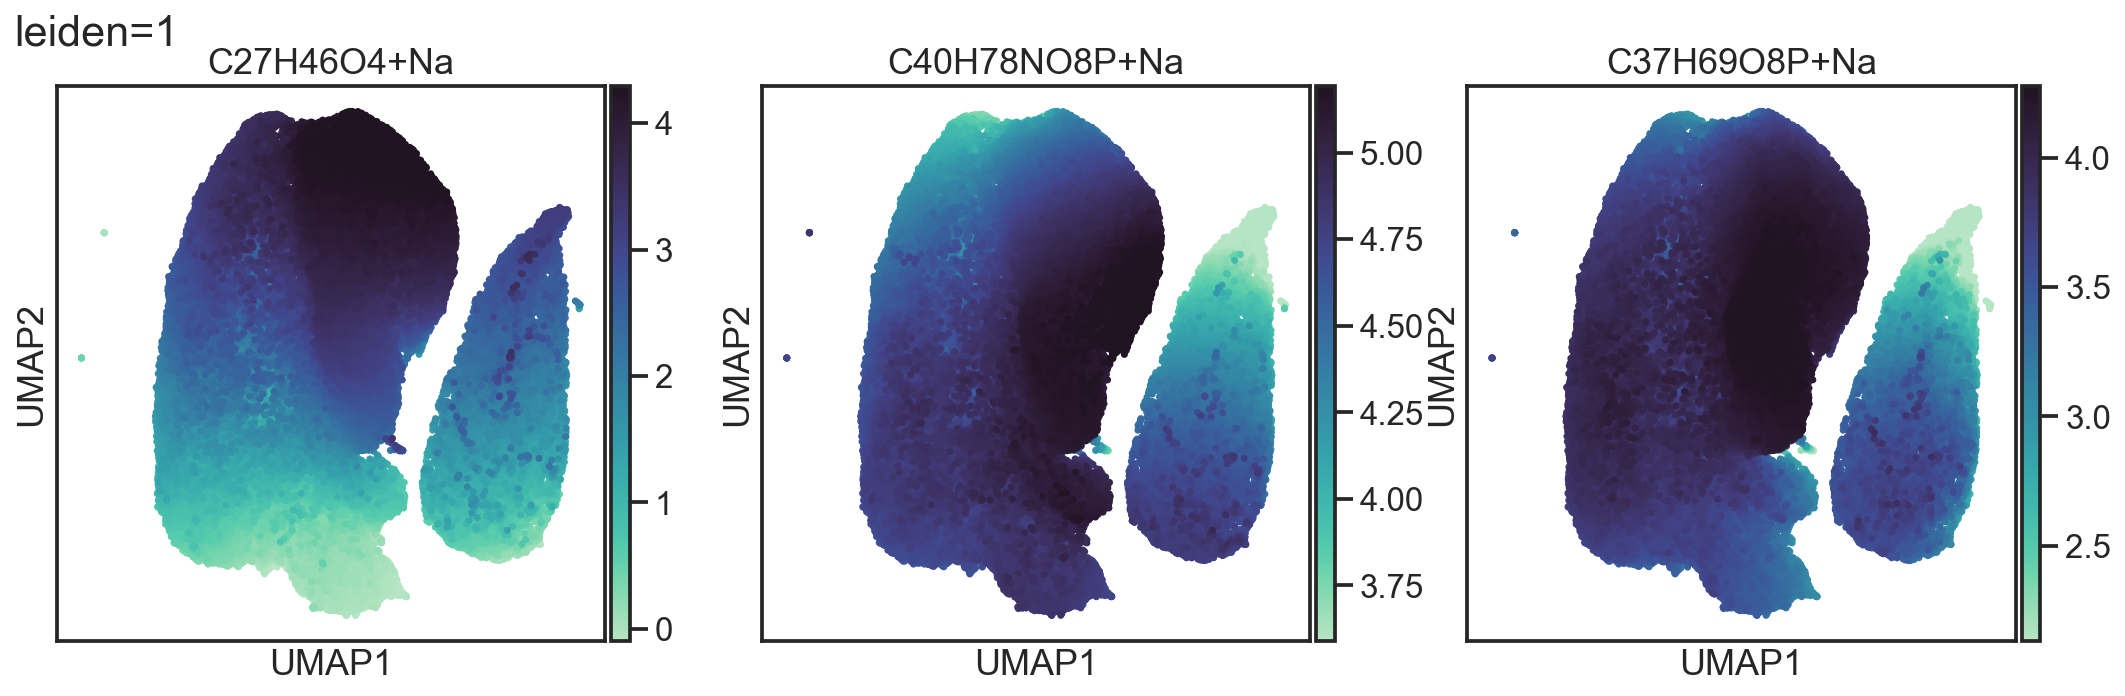

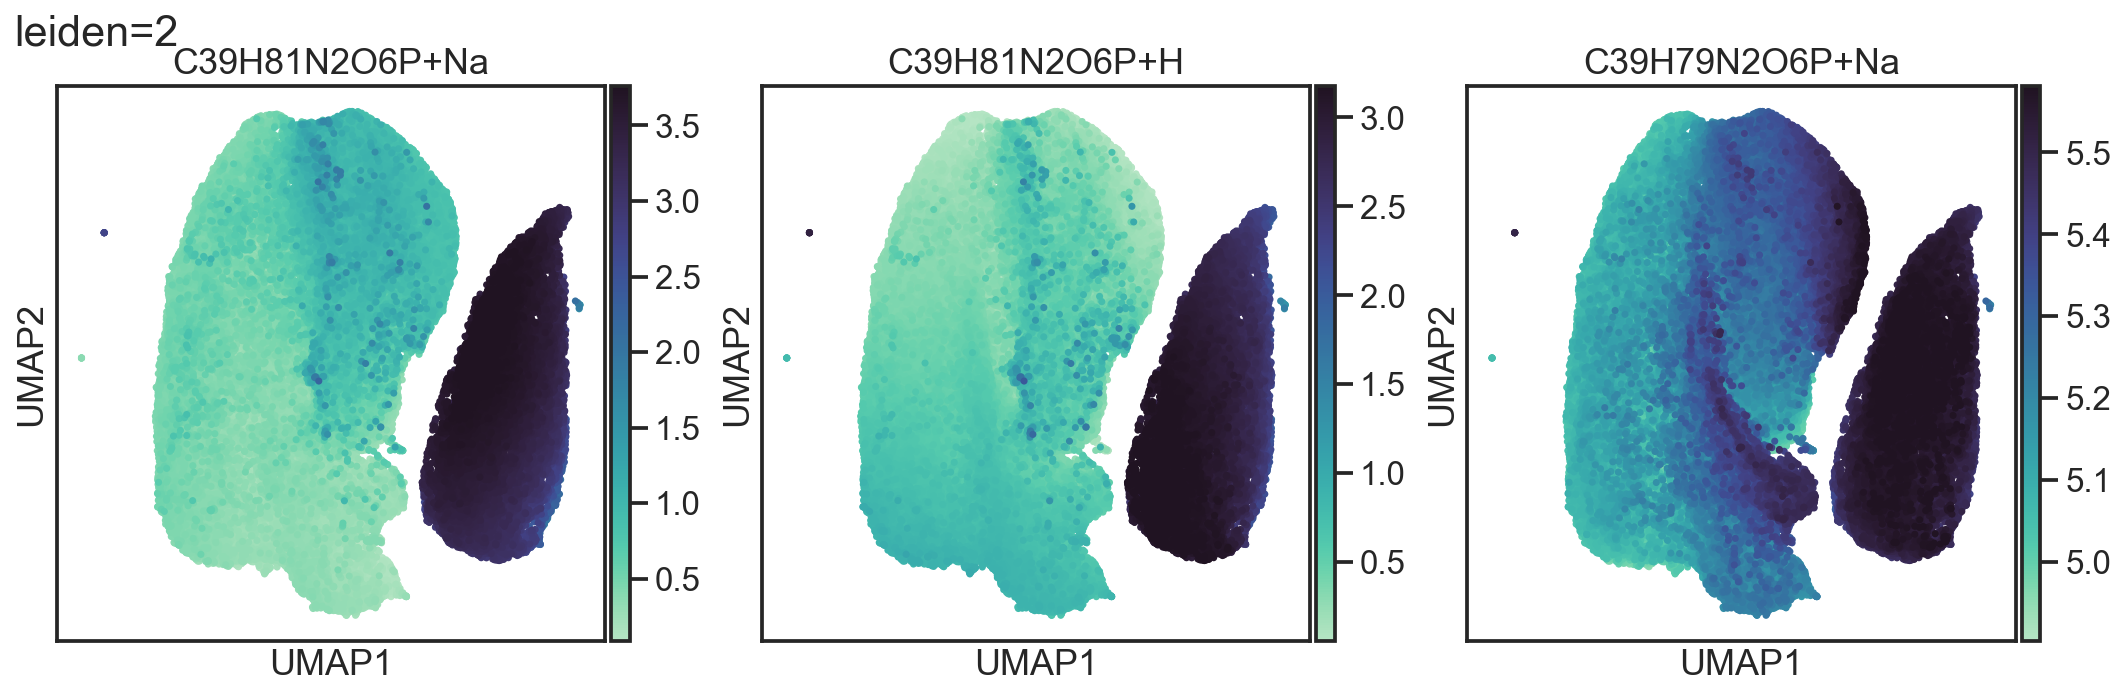

In [58]:
groupname = adata_magic.uns["rank_genes_groups"]["params"]["groupby"] # = "leiden"
top_n = 3

for group in adata_magic.obs[groupname].unique().categories:
    df = sc.get.rank_genes_groups_df(adata_magic, group)
    df = df.sort_values("scores", ascending=False)
    ions = df.iloc[:top_n].names.tolist()
    
    f = sc.pl.umap(
        adata_magic,
        color=ions,
        cmap="mercury",
        s=50,
        layer="clipped",
        show=False
    )
    
    fig = f[0].figure
    fig.suptitle(f"{groupname}={group}", x=0.05, y=1, ha="left")
    fig.savefig(plot_dir / "significant_ions_leiden_{}.png".format(group))

Furthermore, we can check the distribution of p-values and logfoldchanges in a volcano plot:

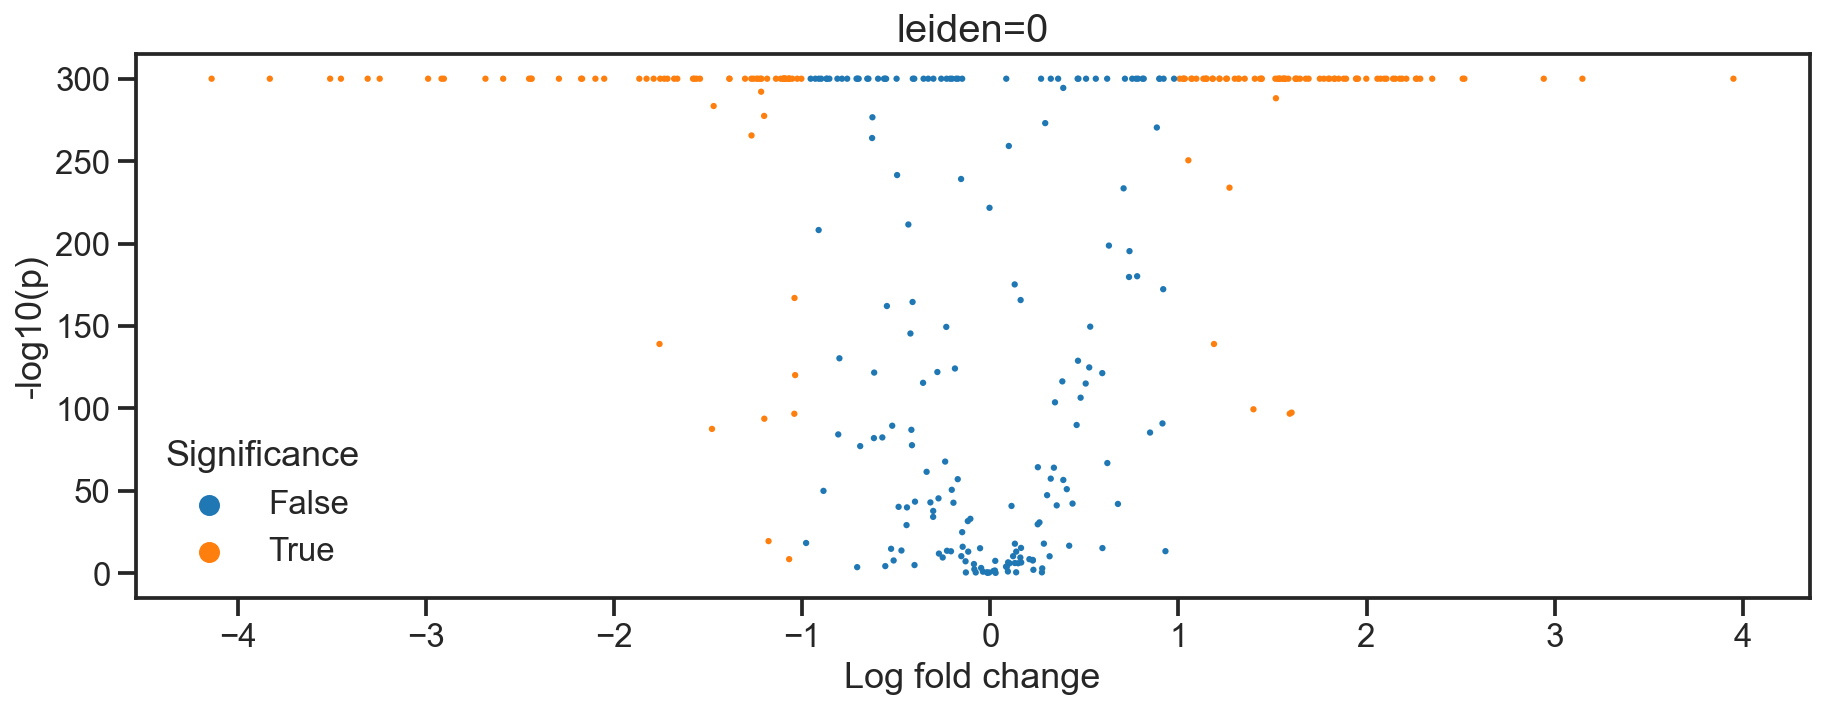

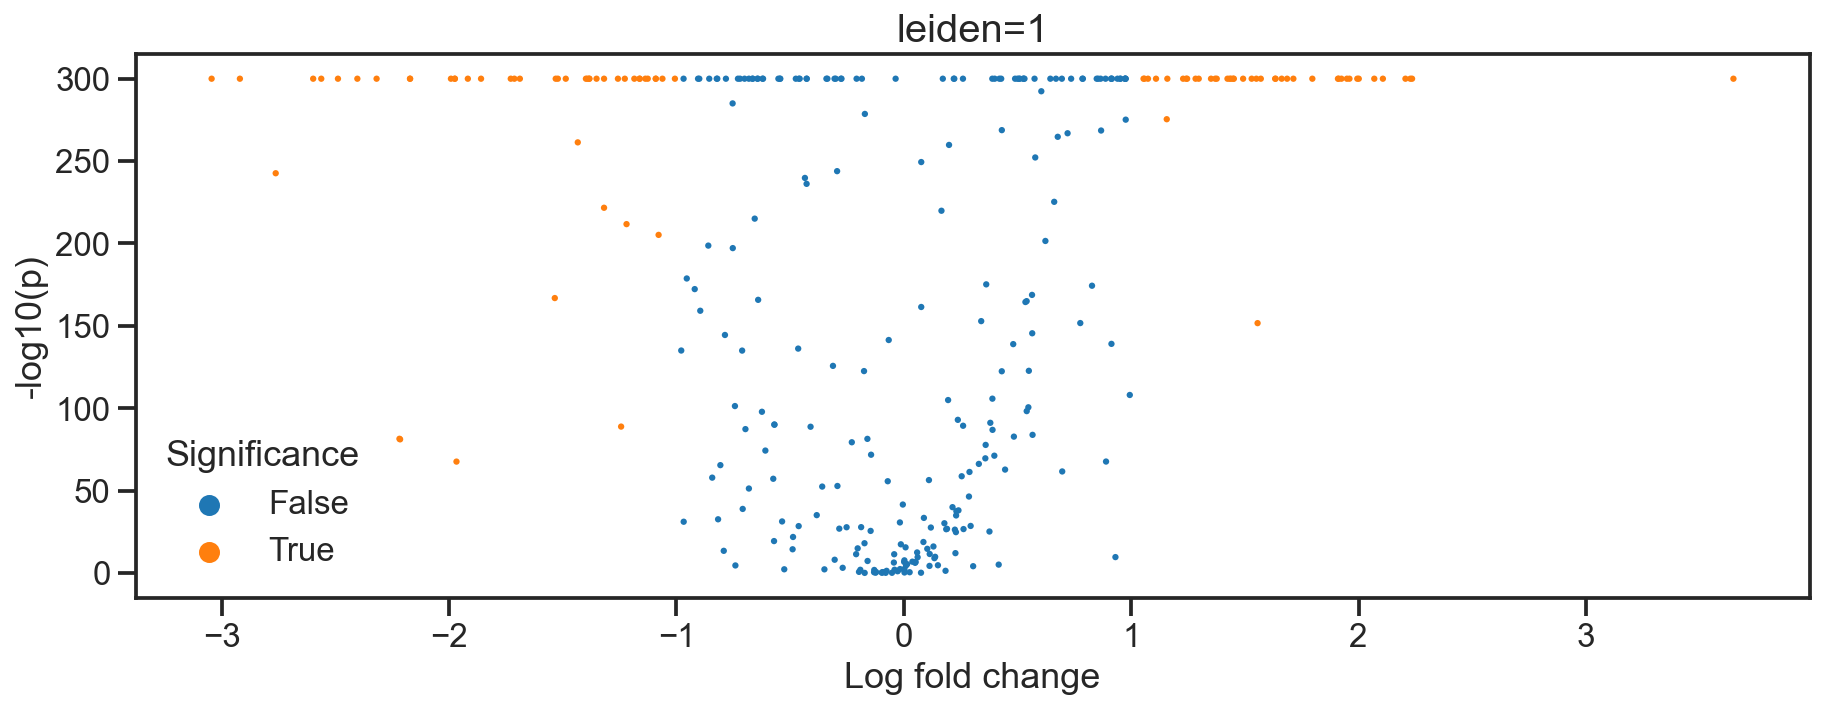

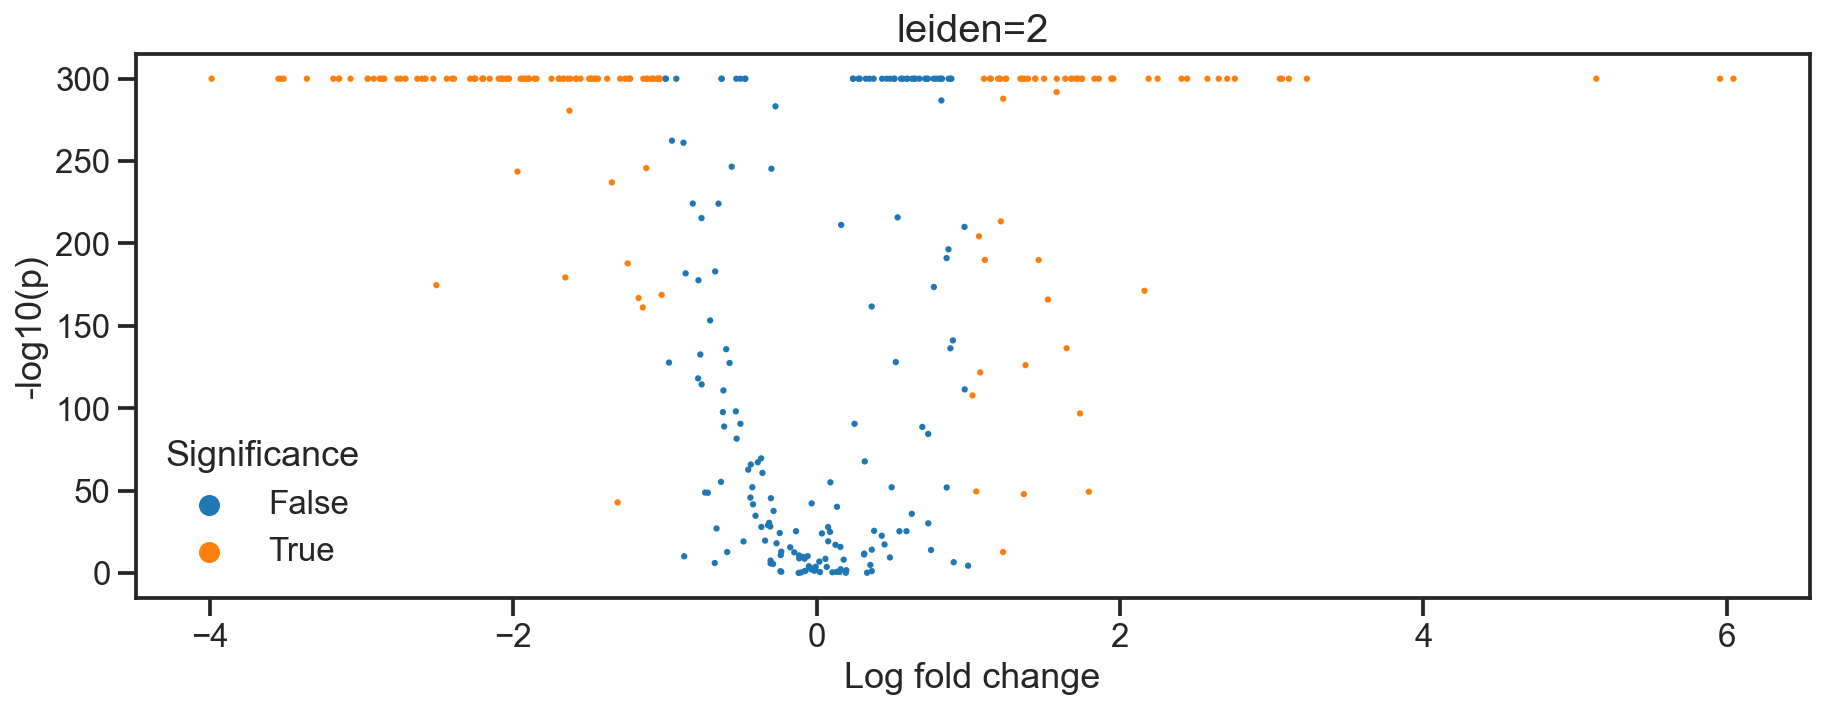

In [59]:
pval_thres = 0.05 # upper threshold for p-values
fc_thres = 2 # lower threshold for fold changes

for group in adata_magic.obs[groupname].unique().categories:
    df = sc.get.rank_genes_groups_df(adata_magic, group)
    df = df.sort_values("scores", ascending=False)

    df.insert(0, groupname, group)
    
    df["significance"] = (df["pvals_adj"] < pval_thres) & (df["logfoldchanges"].abs() > np.log2(fc_thres))
    df["pvals_adj_nlog10"] = -np.log10(df["pvals_adj"] + 1e-300)
    
    plt.figure(figsize=[15, 5])
    sns.scatterplot(
        data = df,
        x = "logfoldchanges",
        y = "pvals_adj_nlog10",
        s = 10,
        linewidth = 0,
        hue = "significance",
        palette = "tab10"
    )
    plt.xlabel("Log fold change")
    plt.ylabel("-log10(p)")
    plt.legend(loc="lower left", title="Significance")
    plt.title(f"{groupname}={group}", fontsize=20)
    plt.savefig(plot_dir / "volcano_leiden_{}.png".format(group))
    plt.show()

Unfortunately, the volcano plots on SpaceM usually looks pretty messy...

Nonetheless, we can now export these markers to use them in other analyses:

In [ ]:
output_dir = plot_dir / "single-cell"

for group in adata_magic.obs[groupname].unique().categories:
    df = sc.get.rank_genes_groups_df(adata_magic, group)
    df = df.sort_values("scores", ascending=False)

    df.insert(0, groupname, group)
    
    df = df[
        (df["pvals"] < pval_thres) & 
        (df["logfoldchanges"].abs() > np.log2(fc_thres))
    ]

    df_path = f"{output_dir}/{groupname}_{group}_markers.tsv"
    print(df_path)
    df.to_csv(df_path, index=False, sep='\t')
